In [1]:
from gdt.core import data_path

### Definiendo los paths a mano
object_no = '090926181'
object_name = f'bn{object_no}'
common_str = f'datos/{object_no}/glg_cspec_'
filepaths = [
    f"{common_str}b0_{object_name}_v00.pha", #0
    f"{common_str}n0_{object_name}_v00.pha", #1
    f"{common_str}n1_{object_name}_v00.pha", #2
    f"{common_str}n3_{object_name}_v00.pha", #3
    f"{common_str}n6_{object_name}_v00.pha", #4
    f"{common_str}n7_{object_name}_v00.pha"  #5
]

In [2]:
from gdt.missions.fermi.gbm.phaii import GbmPhaii

# open the downloaded data
cspec_b0=GbmPhaii.open(filepaths[0]) 
cspec_n3=GbmPhaii.open(filepaths[3]) 
cspec_n6=GbmPhaii.open(filepaths[4]) 
cspec_n7=GbmPhaii.open(filepaths[5]) 

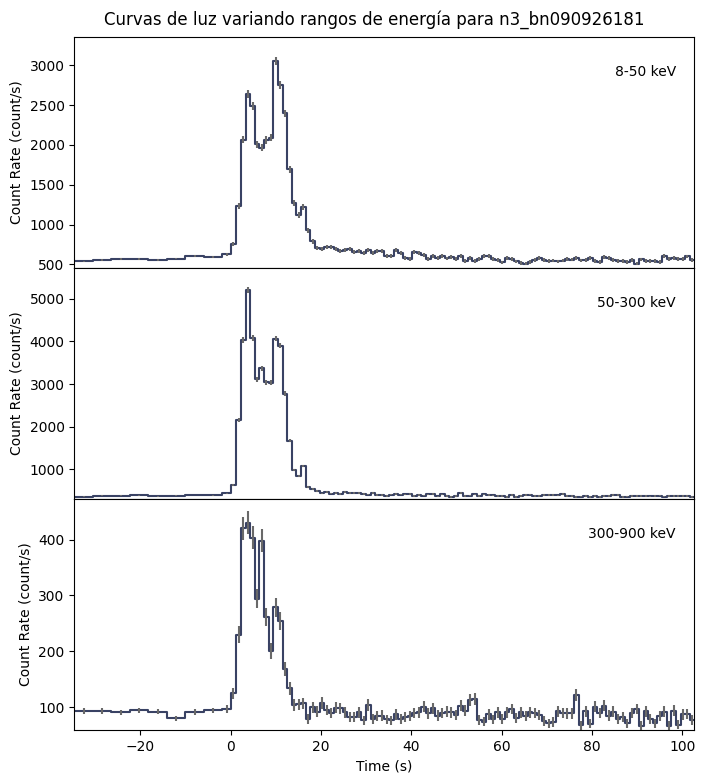

In [3]:
import matplotlib.pyplot as plt
from gdt.core.plot.lightcurve import Lightcurve

# definimos los tres rangos de energía
range1 = (8.0, 50.0)
range2 = (50.0, 300.0)
range3 = (300.0, 900.0)

t_r = (-33, 102)

# Creamos los datos de la curva de luz para cada rango de energía
lc_data1 = cspec_n3.to_lightcurve(time_range=t_r, energy_range=range1)
lc_data2 = cspec_n3.to_lightcurve(time_range=t_r, energy_range=range2)
lc_data3 = cspec_n3.to_lightcurve(time_range=t_r, energy_range=range3)

# Creamos una figura y los ejes para las gráficas, compartiendo el eje x
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
fig.subplots_adjust(hspace=0)

# Graficamos cada curva de luz en su respectivo eje
lightcurve_b0 = Lightcurve(data=lc_data1, ax=ax1)
lightcurve_b1 = Lightcurve(data=lc_data2, ax=ax2)
lightcurve_b2 = Lightcurve(data=lc_data3, ax=ax3)

ax1.text(0.97, 0.88, '8-50 keV',
         transform=ax1.transAxes,
        #  fontsize=12,
         verticalalignment='top',
         horizontalalignment='right')

ax2.text(0.97, 0.88, '50-300 keV',
         transform=ax2.transAxes,
        #  fontsize=12,
         verticalalignment='top',
         horizontalalignment='right')

ax3.text(0.97, 0.88, '300-900 keV',
         transform=ax3.transAxes,
        #  fontsize=12,
         verticalalignment='top',
         horizontalalignment='right')

# Mostramos la gráfica
fig.suptitle(f'Curvas de luz variando rangos de energía para n3_{object_name}', y=0.91)
plt.savefig(r'imagenes/lc_n3.png', bbox_inches='tight')
plt.show()

Generamos la curva de luz y su espectro del detector n3, como ejemplo

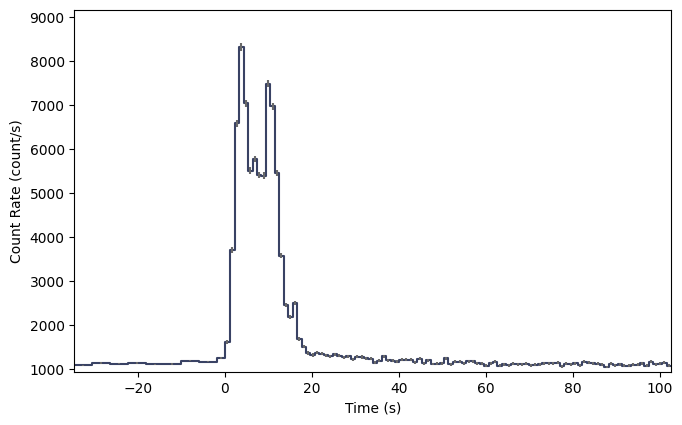

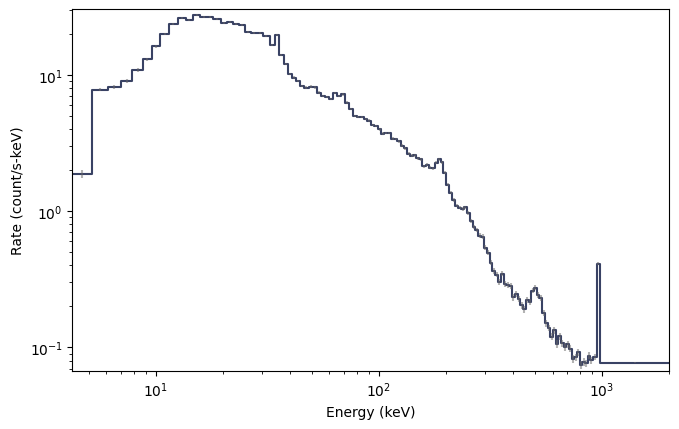

In [4]:
from gdt.core.plot.lightcurve import Lightcurve
from gdt.core.plot.spectrum import Spectrum

import matplotlib.pyplot as plt

# create and show a plot of the lightcurve using data from the b0 detector
lightcurve_b0 = Lightcurve(data=cspec_n3.to_lightcurve(time_range=(-33,102)))
plt.show(lightcurve_b0)

# create and show a plot of the count spectrum using data from the b0 detector
specplot_b0 = Spectrum(data=cspec_n3.to_spectrum(time_range=(-33,102)))
plt.show(specplot_b0)

Añadimos la curva de luz del detector n3 a la colección. Aunque de momento solo trabajemos con un detector, esto hará más flexible el código en el futuro.

In [5]:
from gdt.missions.fermi.gbm.collection import GbmDetectorCollection

# group data from multiple detectors together in a "collection"
cspecs = GbmDetectorCollection.from_list([cspec_n3, cspec_n6, cspec_n7, cspec_b0])

Definimos rangos

In [56]:
# view_range=(-33,102) # source range - the time range that we want to zoom in on
view_range=(-50,100) # source range - the time range that we want to zoom in on
bkgd_range=[(-50, -10), (30, 100)] # background range - the time range where we are observing only the background radiation
energy_range_nai=(8,900) # energy range for the NaI detectors
energy_range_bgo=(325,35000) # energy range for the BGO detectors
src_range=(1,2) # source range - the time range during which the actual burst/event occurs

In [57]:
from gdt.core.background.fitter import BackgroundFitter
from gdt.core.background.binned import Polynomial

# initialize the background fitters and add them to the collection, making sure the collection knows which background goes to which detector
backfitters = [BackgroundFitter.from_phaii(cspec, Polynomial, time_ranges=bkgd_range) for cspec in cspecs]
backfitters = GbmDetectorCollection.from_list(backfitters, dets=cspecs.detector())

In [58]:
# perform the background fit, selecting an order of polynomial to do so
backfitters.fit(order=0)

# calculate chi squared over the degrees of freedom for the first detector in the collection (the b0 detector)
chisq_dof_b0 = backfitters.statistic()[0]/backfitters.dof()[0]

# plot the energy vs. chisq/dof graph, where the energy is our selected energy range for the BGO detectors
# plt.xlabel("Energy (keV)")
# plt.ylabel("Chisq / D.O.F")
# bgfit_b0=plt.plot(np.linspace(energy_range_bgo[0],energy_range_bgo[1],len(chisq_dof_b0)), chisq_dof_b0)
# plt.show(bgfit_b0)

In [59]:
# interpolate the fits
bkgds = backfitters.interpolate_bins(cspecs.data()[0].tstart, cspecs.data()[0].tstop)

# store the background fits in a collection
bkgds = GbmDetectorCollection.from_list(bkgds, dets=cspecs.detector())

In [60]:
# the lightcurves:
data_lcs = cspecs.to_lightcurve(nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})
# the energy-integrated background:
bkgd_lcs = bkgds.integrate_energy(nai_args=energy_range_nai, bgo_args=energy_range_bgo)
# the source time selection:
src_lcs = cspecs.to_lightcurve(time_range=src_range, nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})

# the count spectra:
data_specs = cspecs.to_spectrum(time_range=src_range)
# the time-integrated background: 
bkgd_specs = bkgds.integrate_time(*src_range)
# the energy selection: 
src_specs = cspecs.to_spectrum(time_range=src_range, nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})

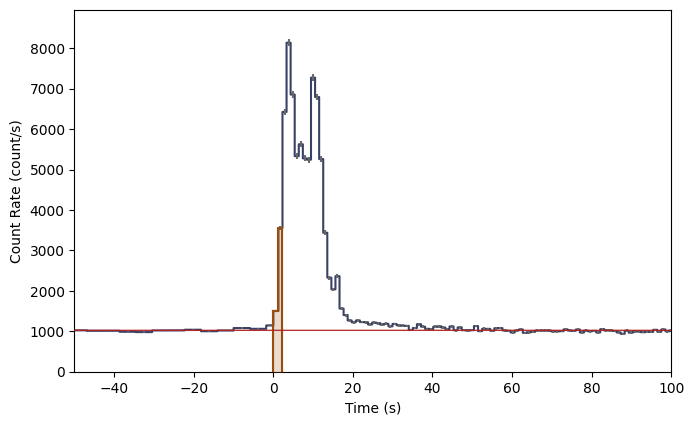

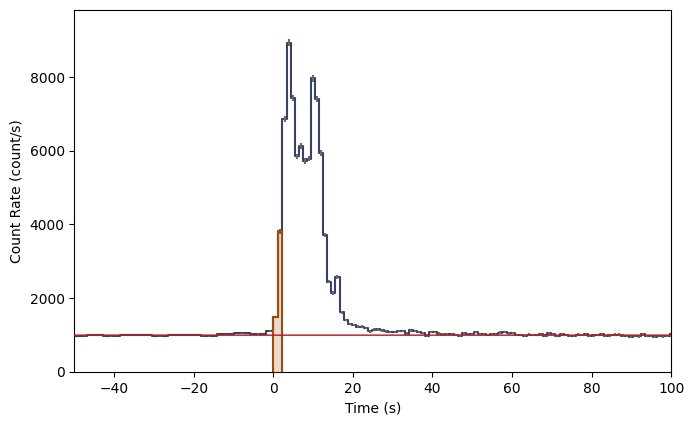

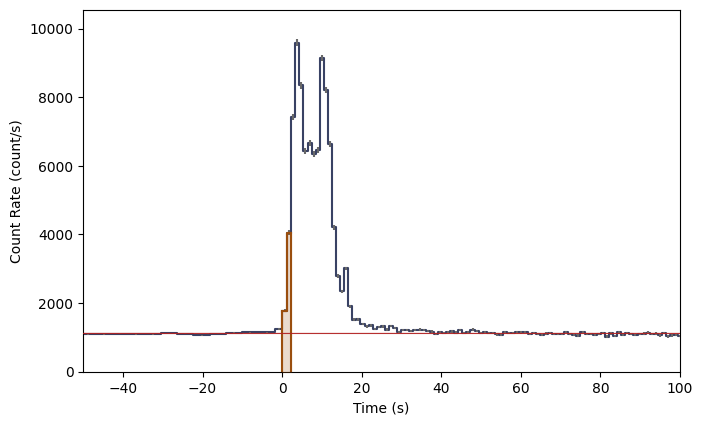

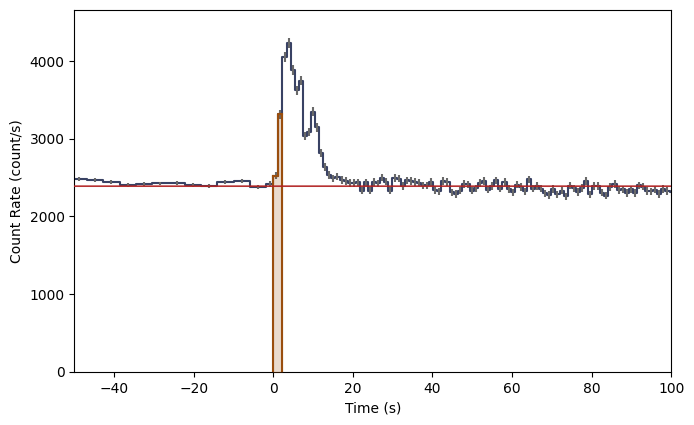

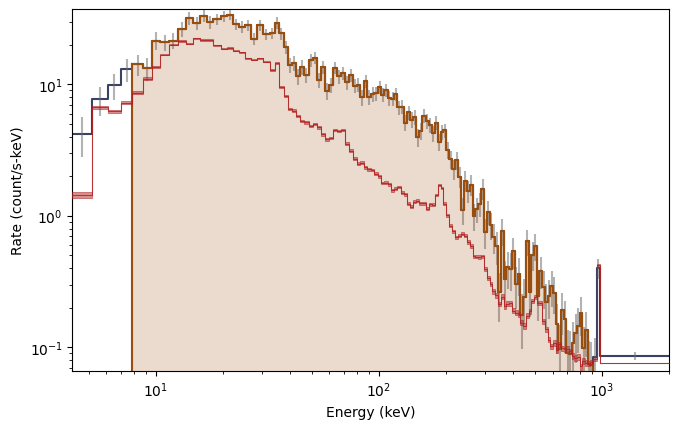

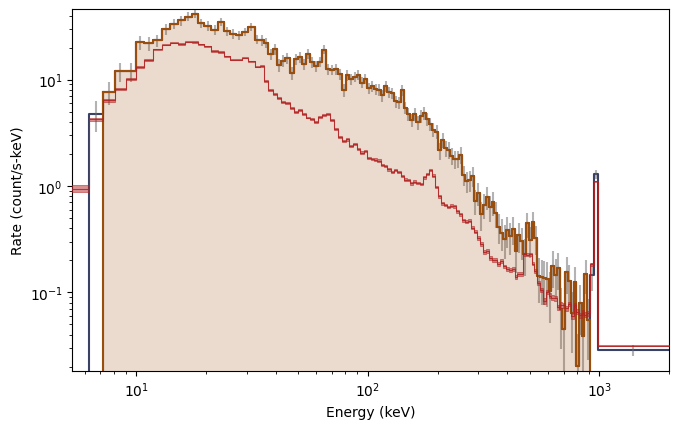

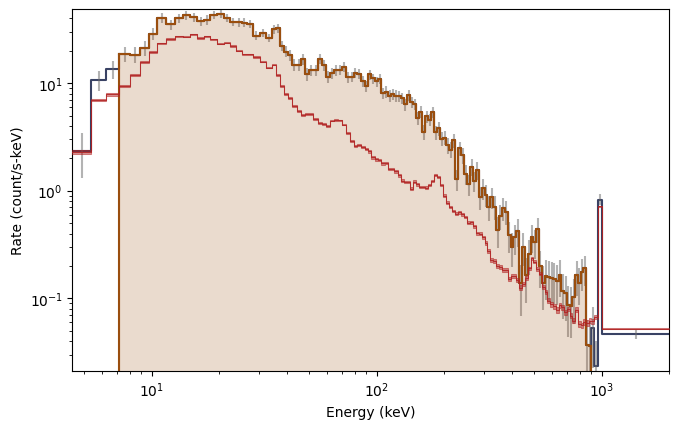

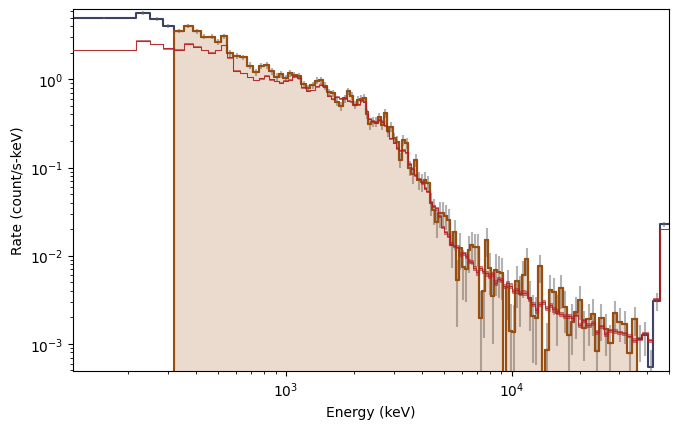

In [61]:
%matplotlib inline
from gdt.core.plot.lightcurve import Lightcurve
from gdt.core.plot.spectrum import Spectrum

# plot the lightcurves, including source selections and background fits
lcplots = [Lightcurve(data=data_lc, background=bkgd_lc) for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)]
_ = [lcplot.add_selection(src_lc) for lcplot, src_lc in zip(lcplots, src_lcs)]
# zoom in to the view range on the lightcurves
for lcplot in lcplots:
    lcplot.xlim = view_range

# plot the count spectra, including source selections and background fits
specplots = [Spectrum(data=data_spec, background=bkgd_spec) for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)]
_ = [specplot.add_selection(src_spec) for specplot, src_spec in zip(specplots, src_specs)]

In [62]:
# convert cspec files from phaii objects to pha objects
phas = cspecs.to_pha(time_ranges=src_range, nai_kwargs={'energy_range':energy_range_nai}, bgo_kwargs={'energy_range':energy_range_bgo})

In [63]:
from gdt.core import data_path

### Definiendo los paths a mano
object_no = '090926181'
object_name = f'bn{object_no}'
common_str = f'datos/{object_no}/glg_cspec_'
filepaths = [
    f"{common_str}n3_{object_name}_v00.rsp2", #0
    f"{common_str}n6_{object_name}_v00.rsp2", #1
    f"{common_str}n7_{object_name}_v00.rsp2",  #2
    f"{common_str}b0_{object_name}_v00.rsp2"  #3
]

# rsps = GbmDetectorCollection.from_list([rsp_n3, rsp_n6, rsp_n7])

# # interpolate the data at the central time
# rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

In [64]:
from gdt.missions.fermi.gbm.response import GbmRsp2

# open the downloaded data
rsp_n3=GbmRsp2.open(filepaths[0]) 
rsp_n6=GbmRsp2.open(filepaths[1]) 
rsp_n7=GbmRsp2.open(filepaths[2])
rsp_b0=GbmRsp2.open(filepaths[3])

# gather the downloaded data in a collection
rsps = GbmDetectorCollection.from_list([rsp_n3, rsp_n6, rsp_n7, rsp_b0])

# interpolate the data at the central time
rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

In [65]:
from gdt.core.spectra.fitting import SpectralFitterPgstat

# initialize the spectral fitter with the .pha files, backgrounds, and interpolated response files
specfitter = SpectralFitterPgstat(phas, bkgds.to_list(), rsps_interp, method='TNC')

In [66]:
from gdt.core.spectra.functions import Band

# initialize the comptonized function
band = Band()

# view the list of parameters, their default values, their minimum and maximum values, etc. 
print(band.param_list)
print(band.default_values)
print(band.min_values)
print(band.max_values)

[('A', 'ph/s/cm^2/keV', 'Amplitude'), ('Epeak', 'keV', 'SED Peak'), ('alpha', '', 'Low-Energy Photon index'), ('beta', '', 'High-Energy Photon index'), ('Epiv', 'keV', 'Pivot energy')]
[0.01, 500.0, -0.5, -2.5, 100.0]
[1e-10, 0.01, -1.9, -10.0, 0.01]
[inf, inf, 20.0, -2.0001, inf]


In [67]:
# perform the fit and see if it converged
print('Band Fit:')
specfitter.fit(band, options={'maxiter': 1000})
print(specfitter.message)

# show the maximum likelihood parameter values
print('Parameters: {}'.format(specfitter.parameters))

# show errorbar values on either side of the parameters with 90% confidence interval
print('90% Asymm. Errors:\n {}'.format(specfitter.asymmetric_errors(cl=0.9)))

# show the fit statistic and degrees of freedom
print('Pgstat/DoF: {}/{}'.format(specfitter.statistic, specfitter.dof))

Band Fit:
Linear search failed
Parameters: [ 8.54493538e-02  2.90970968e+02 -3.95606924e-01 -2.00010000e+00]
90% Asymm. Errors:
 [[2.86502509e-03 2.90381110e-03]
 [1.12985352e+01 1.16608855e+01]
 [5.31412798e-02 5.59347227e-02]
 [1.42617776e-01 0.00000000e+00]]
Pgstat/DoF: 256.14241172376785/480


/home/toledo/.cache/pypoetry/virtualenvs/astrogrb-ZjSpyhWB-py3.13/lib/python3.13/site-packages/gdt/core/spectra/fitting.py:371: UserWarning: Parameter exists at its upper bound
  warnings.warn("Parameter exists at its upper bound")


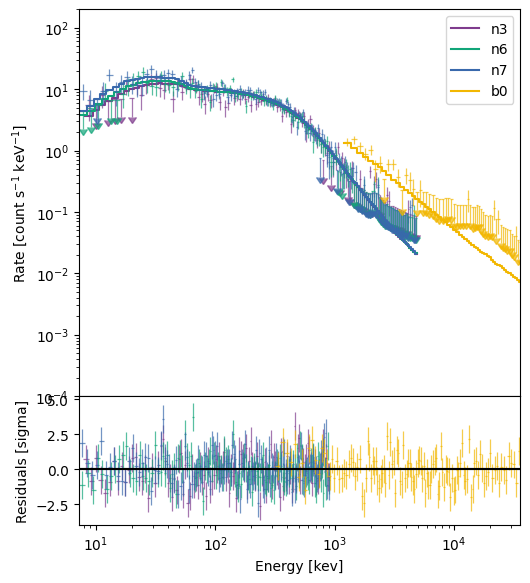

In [68]:
from gdt.core.plot.model import ModelFit

# initialize with your spectral fitter once the fit is done
modelplot = ModelFit(fitter=specfitter)

# we need to zoom in on this particular plot, which is easy to do with the residuals temporarily hidden
ModelFit.hide_residuals(modelplot)
plt.ylim(1e-4,200)
plt.xlim(7.15,4000)
ModelFit.show_residuals(modelplot)